This code is a modified version of @filthyQuants code from tik tok, the original code backtested a 50 day moving average strategy. I have expanded it to consider other strategies such as an exponential moving average, a crossover moving average and and a coin flip strategy.

In [92]:
import yfinance as yf
import pandas   as pd
import numpy    as np
import random
from numba import jit, njit, types, vectorize, prange
import plotly.express as plt

If you interested in the way this code works you can find each of the strategies and the code to implement them below. If you arent scroll down to see the implementation to mess around with the various parameters.

In [93]:
#First we need to retreive the data to do any of the testing against. 

def getdata(stockname,testperiod, datatype, interval1):
    yfdata = yf.Ticker("{}".format(stockname)).history(period=str(testperiod),interval = interval1)
    closedata = yfdata[datatype].copy()
    return closedata

In [94]:
#Defining a function to take the moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days

def sma(data_levels,days = 50, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #Second we take the data and add a new collumn that has the moving cost average where we will name the new collumn SMA with the 
    # subscript of the number of days being considred
    
    data['SMA_{}'.format(days)]  = data.iloc[:,0].rolling(days).mean()
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on dat of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty collumns, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price + tollerance > SMA = buy
        if data['Close'].iloc[i] + tollerence*data['Close'].iloc[i] > data['SMA_{}'.format(days)].iloc[i]:
            signals.append(1)
        
        # if Current price < SMA tollerance = sell
        elif data['Close'].iloc[i] < data['SMA_{}'.format(days)].iloc[i] +tollerence*data['Close'].iloc[i]:
            signals.append(-1)
            
        # if Current Price is too close to SMA we wont do anything
        else: 
            signals.append(0)
            
    data['Signals'] = signals
    return data

In [95]:
#Defining a function to take the exponential moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days

def ema(data_levels,days = 50, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new collumn that has exponential weighted average. EWM method in pandas makes this super easy
    
    data['EMA_{}'.format(days)] = data.iloc[:,0].ewm(span = days).mean()   
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on day of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price > EMA + tollerance = buy
        if data['Close'].iloc[i] > data['EMA_{}'.format(days)].iloc[i] + tollerence*data['Close'].iloc[i]:
            signals.append(1)
        
        # if if Current price + tollerance < EMA = sell
        elif data['Close'].iloc[i] + tollerence*data['Close'].iloc[i]< data['EMA_{}'.format(days)].iloc[i]:
            signals.append(-1)
            
        # if EMA is too close to current price = do nothing
        else: 
            signals.append(0)
            
    data['Signals'] = signals 
    
    return data

In [96]:
#Defining a function to find the signals of a moving crossover strategy

def mxa(data_levels,daysshort = 50, dayslong =200, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new collumn that has the 50 day average
    
    data['SMA_{}'.format(daysshort)]  = data.iloc[:,0].rolling(daysshort).mean()
    
    #make another that has the 200 day average 
    
    data['SMA_{}'.format(dayslong)]  = data.iloc[:,0].rolling(dayslong).mean()
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on day of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if 50 day average > 200 day average +tollerance = buy
        if data['SMA_{}'.format(daysshort)].iloc[i] > data['SMA_{}'.format(dayslong)].iloc[i]+ tollerence*data['Close'].iloc[i]:
            signals.append(1)
        
        # if 50 day average +tollerance < 200 day average = sell
        elif data['SMA_{}'.format(daysshort)].iloc[i] + tollerence*data['Close'].iloc[i] < data['SMA_{}'.format(dayslong)].iloc[i]:
            signals.append(-1)
            
        # if the two averages are close to one another then we wont do anything
        else:
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

In [97]:
def rsi(data_levels, rsi_days = 14 , overbought= 70, oversold =30):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    data = data.dropna()
    
    #we also need a percentage change column so we can split the gains and losses     
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #next we are going to make two collumns one for the gains one for the losses,
    #we are trying to avoid doing this in for loops so that it is a bit quicker
        
    data['gains'] = data['Returns'].apply(lambda x: x if x>0 else 0)
    
    data['losses'] = data['Returns'].apply(lambda x: -x if x<0 else 0)
    
    #then we need the exponential average losses and gains so that we can calculate the RS of the stock this is for the initial values
    
    data['ema_gain'] = data['gains'].ewm(span=rsi_days, min_periods=rsi_days).mean()
    data['ema_loss'] = data['losses'].ewm(span=rsi_days, min_periods=rsi_days).mean()
    
    #then calculate the reletive strength after each close
    
    data['rs'] = data['ema_gain']/data['ema_loss']
    
    #Work out the RSI in every given period 
    
    data['RSI_{}'.format(rsi_days)] = (100-(100/ (data['rs'] +1)))
    
    #A blank list for the signals to go

    signals = []
       
    #now we need to loop through the data to produce the signals
    
    for i in range(len(data)):
        
        #if the RSI goes above our below then we will buy as we expect an upturn

        if data['RSI_{}'.format(rsi_days)].iloc[i] < oversold:
            signals.append(1)
            
        #if the RSI goes above our threshold we sell
        
        elif data['RSI_{}'.format(rsi_days)].iloc[i] > overbought:
            signals.append(-1)
            
        #else we hold, note that in the first 14 days there wont be any kind of data because the formula doesnt work till day 14
        
        else:
            signals.append(0)
    data['Signals'] = signals
    return data

In [98]:
def randomtrading(data_levels, probabilitybuy = 0.5, probabilitysell = 0.5,probabilitydonothing= 0):
    
    #first just clean up the data so there are no differencs with the above code.
    
    data = pd.DataFrame(data_levels).copy()
    data = data.dropna()

    #adding this if in so that we make sure the probabilities actually add up to 1
    
    if probabilitybuy+probabilitydonothing+probabilitysell <= 1 :
        
        #make a list to store the signals
        
        randomsignals = []
        
        #loop over the signals and for the buy sell probability if the random number is below the probility threshold we buy, or the probability we 
        
        for i in range(len(data)):
            p = random.random()
            if p<probabilitybuy:
                randomsignals.append(1)
            elif p<probabilitybuy + probabilitysell:
                randomsignals.append(-1)
            elif p >probabilitybuy + probabilitysell:
                randomsignals.append(0)
        data['Signals'] = randomsignals
    else:
        print("probabilities did not sum to 1 or less ")
        randomsignals = np.zeros(len(data))
        data['Signals'] = randomsignals
        
    return data

In [99]:
#now that we have the data make a back tester to check if it will work take the two collumns the price 

def backtester(signals,price, tcost = 0.001):

#Make a quick numpy array to save the money that willbe made for posible value that the stock could be sold at and the cash on hand, start with one dollar so its not empty.

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1
        
        #loop throgh each day as though we are going through and actually implementing the strategy as we go

        for i,val in enumerate(price):
            
            #if we are on the last day exit the loop we are done.

            if i == len(price)-1:
                break
            
            # if the signal that that day is to sell the on the next day we should have the possible value of the coin, 
            # times the price of the coin times the brokerage costs plus the money we had perviously.
            # We also sell all of the coin that we have so the possible value left to us is zero

            if signals[i] == -1:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0
                
            #If the signal that day is to buy, what we will do is take all of the cash that we have, divide it by the cost of the coin to work out how many we can buy
            #factoring in the cost of the brockerage, we then add it to any stock we held from the pervious day

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0
                
            # Lastly we need to define the do nothng clause. this will not make a buy or a sell, we do need to update the position value to be the number of stocks/coins we own times that days price
                
            elif signals[i] == 0:
                
                pos_val[i+1] = pos_val[i]/price[i]*price[i+1]
                cash[i+1] = cash[i]
                
        #then our returns are the amount of cash left each day plus the the price times the amoint of coin that we have

        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        #lastly we turn this into a data frame too
        
        return pd.DataFrame(returns, index = price.index)

In [100]:
def winrate(data,returns):

#make an enmpty list to store the number of trades made that were money making. 

    tps = []

    #take all of the signals excluding the first and last ones

    sigs = data['Signals'][1:-1].values.ravel()

    #take the percentage returns day on day, not sure why we are only including the days where there is some kind of buy trade and not a sell trade

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()

    #Record a posative signal every time a trade is made and it results in a posative return.
    
    for i,val in enumerate(sigs):  
        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)

    #Possible other signals that might result in gain, such as holding or selling.

#        if (sigs[i] == -1 and rets[i]>0):
#            tps.append(1)
#        if (sigs[i] == 0 and rets[i]>0):
#            tps.append(1)

    # work out the number of posative signals

    signals, counts = np.unique(sigs, return_counts=True )
    possignals = dict(zip(signals,counts))[1]

    #take the number of buy signals that result in a posative return the next day and divide it by the total number of posative sugnals to work out hte true posative score.

    win_rate = sum(tps)/possignals
    return win_rate



In [101]:
def Sharperatio(returns,tradingdays,rrr):
    
    #First thing to do is to work out the percentage change in the returns for the last year, note that depending on what we are trading there
    #might be a different number of trading days, in the case of Bitcoin the default there are 365, for stocks it is usually 255
    
    lastyearreturns = returns.tail(tradingdays).pct_change().dropna()
    
    # Then working out the sharpe ratio, which is defined as the annuklised rate of return minus the garenteed rate of return divided by the standard deviation
    # of hte returns we need to make sure that we multiply by the 
    
    # Note that we are multiplying the standard deviation by the square root of the trading days, this is because it needs to be the annualised
    # Standard deviation, the daily rate.
    
    sharperatio = (lastyearreturns.mean() * tradingdays - rrr)/(lastyearreturns.std()* np.sqrt(tradingdays))
    
    return sharperatio 
    
    

In [102]:

def runthetests():
    #running through the four fifferent tests and outputting the win rate final returns and making a graph of the 
    # short simple average, long simple average, expenonential average as a graph against close price.
    
    #first thing to do is pull the data from Yahoo finance
    
    closedata = getdata(stockname,testperiod,datatype,interval1)
    
    #Then run it through the various different strategies
    
    #First SMA

    dfsma = sma(closedata, days = shortdays, tollerence= toll)
    retrunssma = backtester(dfsma['Signals'],dfsma['Close'], tcost )
    retrunssma.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving simple moving average strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of SMA '+ str(winrate(dfsma,retrunssma)))
    print('Final return of SMA '+ str(retrunssma.iloc[-1][0]))
    print('Sharpe ratio of SMA '+ str(Sharperatio(retrunssma,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #Second EMA

    dfema = ema(closedata, days = shortdays, tollerence= toll)
    retrunsema = backtester(dfema['Signals'],dfema['Close'], tcost )
    retrunsema.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving expoenential average strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of EMA '+ str(winrate(dfema,retrunsema)))
    print('Final return of EMA '+ str(retrunsema.iloc[-1][0]))
    print('Sharpe ratio of EMA '+ str(Sharperatio(retrunsema,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #third moving cross over strategy

    dfmxa = mxa(closedata,daysshort = 50, dayslong =longdays, tollerence = toll)
    returnsxma = backtester(dfmxa['Signals'],dfmxa['Close'], tcost )
    returnsxma.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving crossover strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of XMA '+ str(winrate(dfmxa,returnsxma)))
    print('Final return of XMA '+ str(returnsxma.iloc[-1][0]))
    print('Sharpe ratio of XMA '+ str(Sharperatio(returnsxma,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #fourth the RSI strategy
    
    dfrsi = rsi(closedata, rsi_days=rsi_period , overbought=overbuy, oversold=oversell)
    returnsrsi = backtester(dfrsi['Signals'], dfrsi['Close'], tcost)
    returnsrsi.plot(xlabel = 'year', ylabel = 'return', title = 'Return RSI strategy {}'.format(stockname),figsize = (25,10))
    dfrsi['RSI_{}'.format(rsi_period)].plot(xlabel = 'year', ylabel = ('RSI_{}'.format(rsi_period)), title = ('RSI indicator over {} days'.format(rsi_period)),figsize = (25,10))
    print('Winrate of RSI '+ str(winrate(dfrsi,returnsrsi)))
    print('Final return of RSI '+ str(returnsrsi.iloc[-1][0]))
    print('Sharpe ratio of RSI '+ str(Sharperatio(returnsrsi,tradingdays=tradingdays,rrr=rrr )[0]))   
    
    #fifth Random coin flips

    dfrandom = randomtrading(closedata, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing )
    returnsrandom = backtester(dfrandom['Signals'],dfrandom['Close'], tcost )
    returnsrandom.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the coinflip strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of coinflips '+ str(winrate(dfrandom,returnsrandom)))
    print('Final return of coinflips  '+ str(returnsrandom.iloc[-1][0]))
    print('Sharpe ratio of coinflips '+ str(Sharperatio(returnsrandom,tradingdays=tradingdays,rrr=rrr )[0]))  

    #put all of the indicators together to make one big graph against the actual close price

    data = pd.DataFrame(closedata).copy()
    data['EMA_{}'.format(shortdays)] = data.iloc[:,0].ewm(span = shortdays).mean()
    data['SMA_{}'.format(shortdays)]  = data.iloc[:,0].rolling(shortdays).mean()
    data['SMA_{}'.format(longdays)]  = data.iloc[:,0].rolling(longdays).mean()

    data[['Close','SMA_{}'.format(shortdays),'SMA_{}'.format(longdays),'EMA_{}'.format(shortdays)]].plot(xlabel = 'year', ylabel = 'USD', title = '{}'.format(stockname) ,figsize = (20,10))


Actually backtesting the code.

The user will need to specify a few things, first which stock or crypto are we going to back test with and the expected transaction cost.

Second is the parametes of the various strategies themselves

Winrate of SMA 0.5563035495716034
Final return of SMA 132.3301833946206
Sharpe ratio of SMA -1.0891581654006528
Winrate of EMA 0.5514929920780012
Final return of EMA 77.580379127737
Sharpe ratio of EMA -0.8984503908413245
Winrate of XMA 0.5478881618084473
Final return of XMA 73.81548049789363
Sharpe ratio of XMA 0.28109346880514696
Winrate of RSI 0.1323529411764706
Final return of RSI 19.957583439519205
Sharpe ratio of RSI -0.1502653569856967
Winrate of coinflips 0.27849355797819625
Final return of coinflips  1.7156195758608517
Sharpe ratio of coinflips -0.6244364576710184


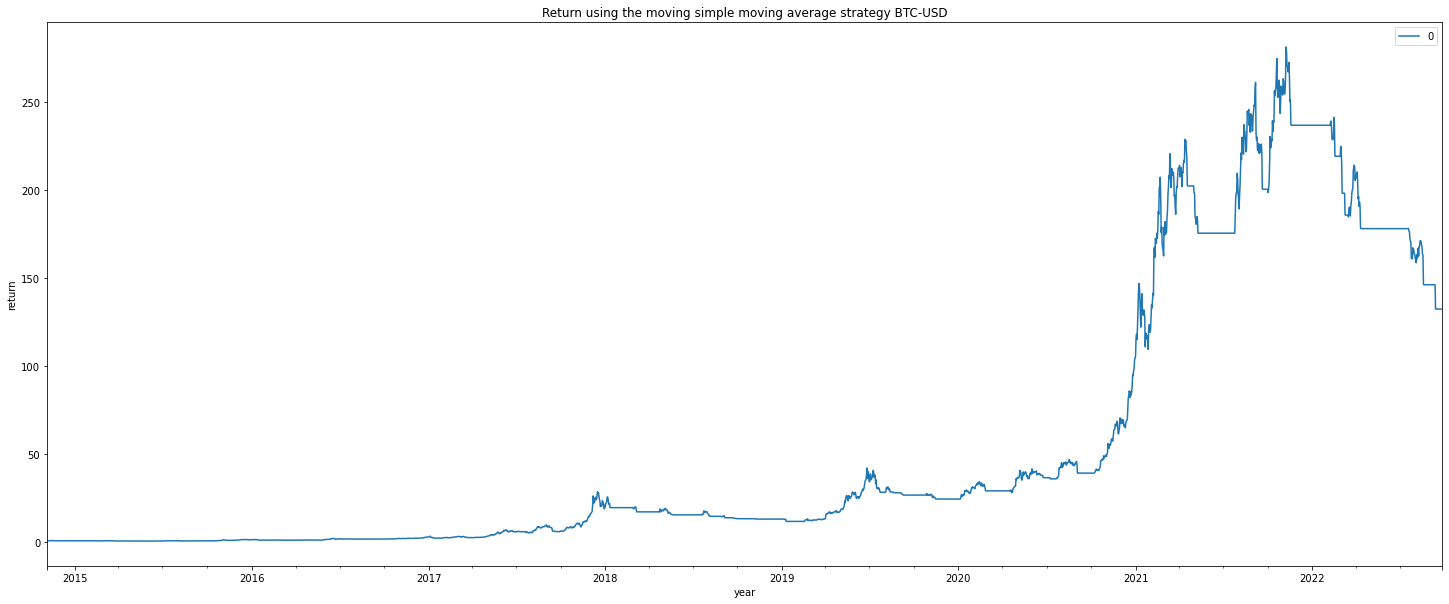

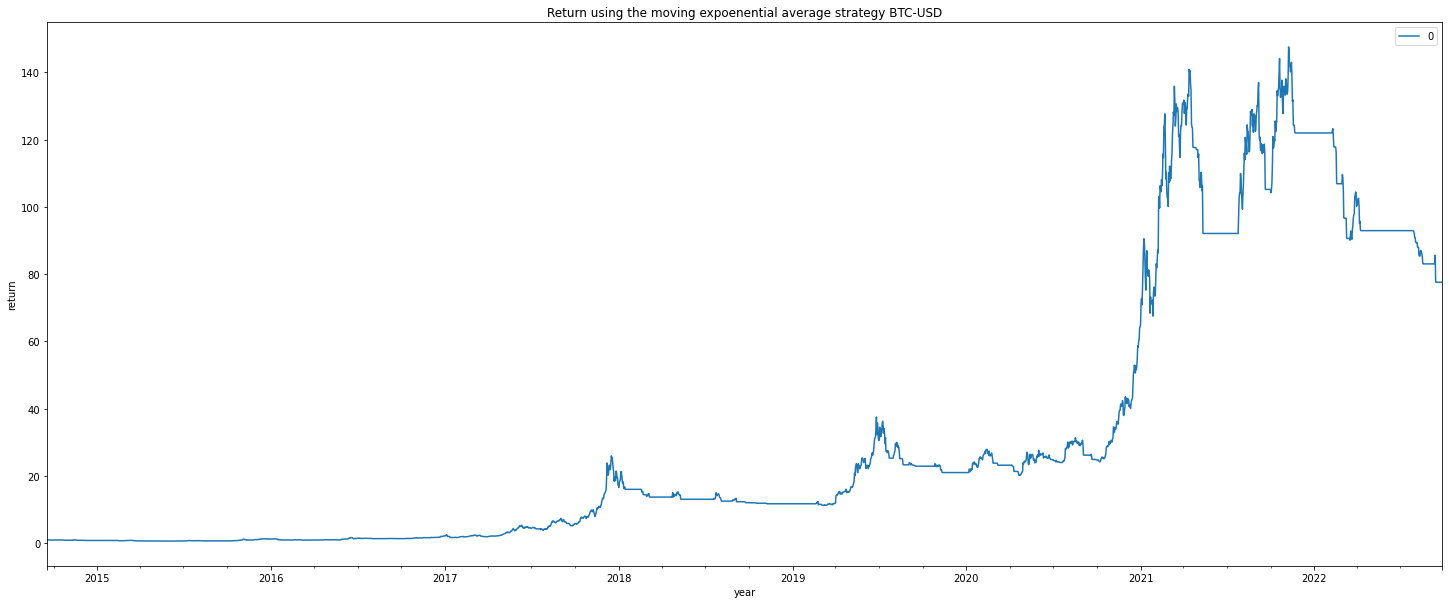

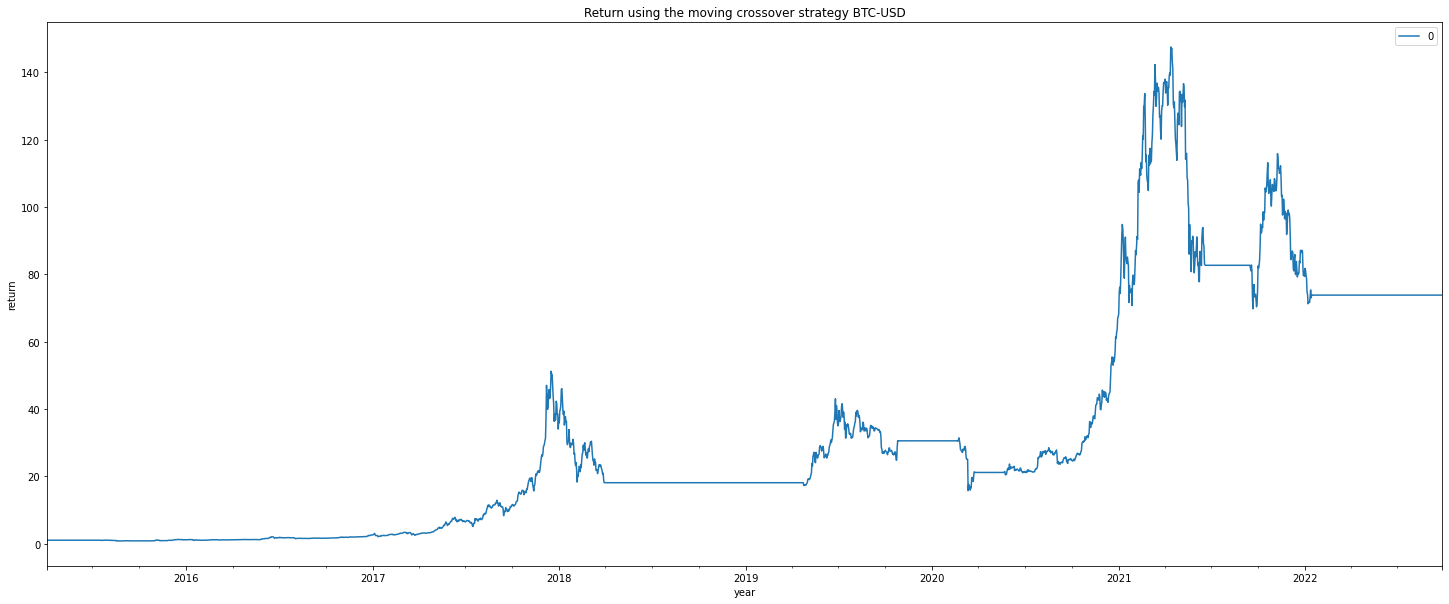

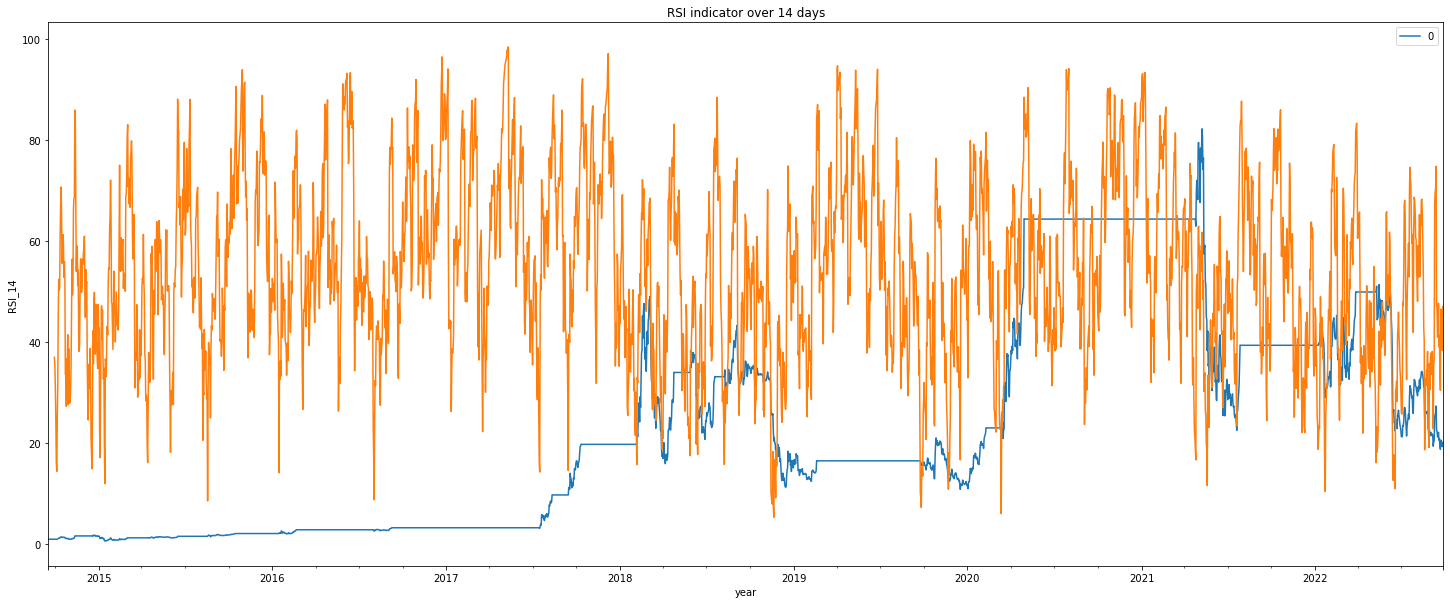

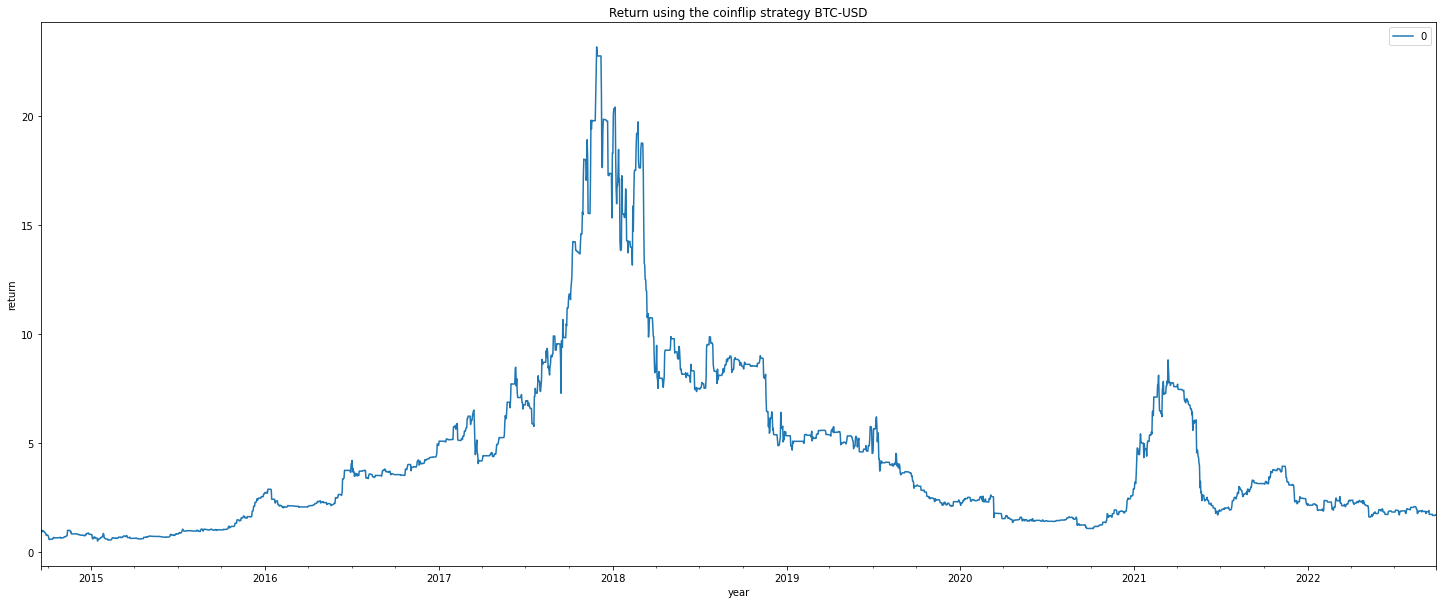

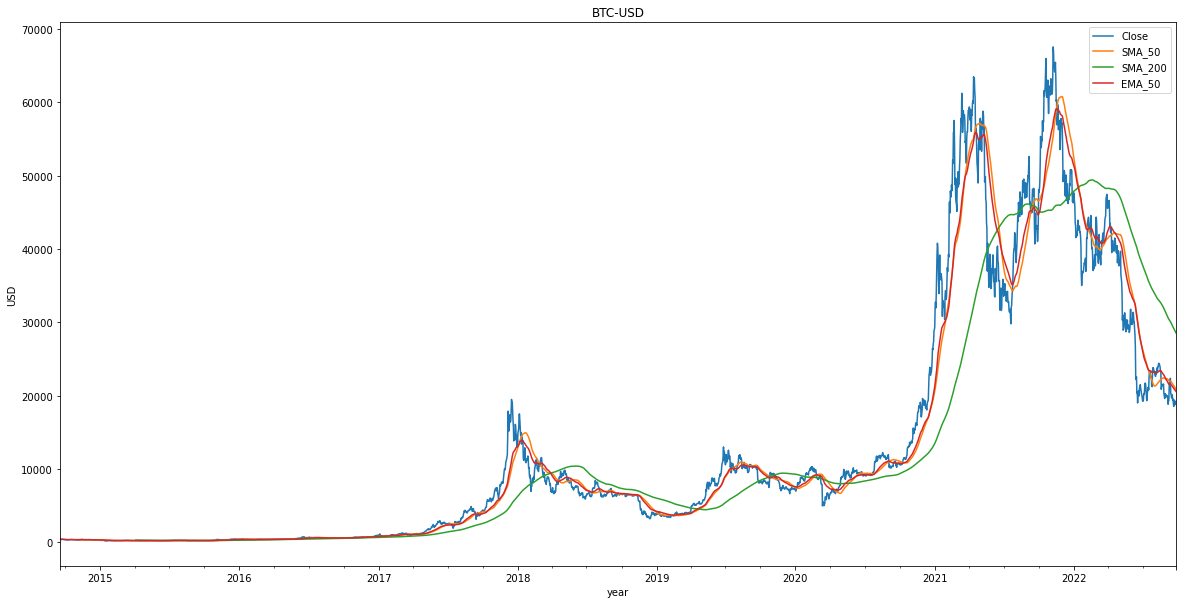

In [103]:
#now lets check the three strategies that have been encoded above to comapre them, this cell once the parameters are entered will run 
#this cell let you define all of the probailities we will be calling on 

#select the stock or coin that you want to back test against and the data point from each day i.e. 'Open','Close','High'etc 

stockname = "BTC-USD"

testperiod = "30y"

datatype= 'Close'

interval1 = '1D'

# This is going to be used as the "risk free" rate of return, as default it is set to 2%, as a fair rate of return
#Given that this is an annulaised rate of return, it will only consider the last year of data

rrr = 0.01

# This is the number of days that the security from above is traded, it might be 365 if it is traded every day or 255 otherwise

tradingdays = 365

#then define the transaction cost 

tcost = 0.001

#define the short averaging period used in SMA EMA and XMA note that this is in the units of the interval, so if it is in weeks it will apply over weeks, for days it will apply over days etc.

shortdays = 50 

#define the long period used in MXA

longdays = 200

# define a tollerance variable, this says by just how much the the averages need to be above or below the close in the case of SMA and EMA price to exercute a trade
# This is tollerance is set as a proportion of the close price that day. 
#set to zero remove it

toll = 0.00
#define the RSI period, typically 14 is used 

rsi_period = 14

#this is the threshold for the rsi indicator that tells you to sell, if the rsi goes over this limit then the theory says that the stock is being sold and is due to revert back the mean. 

overbuy = 80

#this is the threshold for the rsi indicator that tells you to sell, if the rsi indicatior goes below this number then the theory says that ht stock is being over sold and is due to increase in price this number should be lower than the over buy limit

oversell = 20

#lastly for the coin flip the probability of buying, probability of selling and the probability of doing nothing taken as the differnce between probbuy +probsell and 1 

probbuy = 1/3

probsell = 1/3

probdonothing = 1/3

runthetests()

Given that flipping a coin is random process lets test it a 1000 times just to be sure that we didnt just have a very unlucky series of rolls


The average return is: 406.7046950894224
the average win rate is: 0.5338153771735424


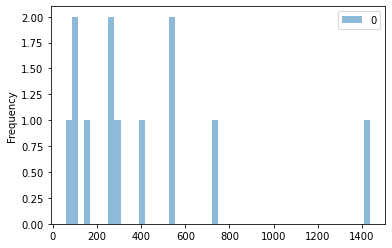

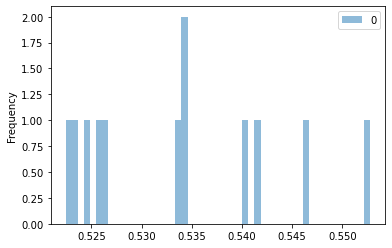

In [104]:

#run the random trial a bunch of times times just to be sure

data_type = 'Close'

interval1 = '1d'

numoftrials = 12

probbuy = 0.5

probsell = 0.000001

probdonothing = 0

finalreturns = []

runningtotalwinrate = []

#get the data 

data = getdata(stockname, testperiod, data_type, interval1)

#experimental jit multithreading, not currently working because pandas dataframes don't work well with jit

#@jit(nogil=True, parallel=True)

def runrandomtrials(trails = 1000):
    for j in range(trails):
        dfrandoms = randomtrading(data, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing ) 
        returnsrandom = backtester(dfrandoms['Signals'],dfrandoms['Close'])
        win = winrate(dfrandoms,returnsrandom)
        finalreturns.append(returnsrandom.iloc[-1])
        runningtotalwinrate.append(win)

#call the function

runrandomtrials(numoftrials)

# the average final return 

print('The average return is: ' + str(sum(pd.DataFrame(finalreturns)[0]/numoftrials)) )

# the average win rate

print('the average win rate is: ' + str(sum(runningtotalwinrate)/numoftrials))

#plotting a historgam to show the final returns and then the win rates

axfinalreturns = pd.DataFrame(finalreturns)[:].plot.hist(bins=50, alpha=0.5)
axwinrates = pd.DataFrame(runningtotalwinrate).plot.hist(bins=50, alpha=0.5)